## Car Customer Segmentation

An autombile company has plans to enter a new market with their existing products. After market research, they've deduced that the behaviour of the new market is similar to their existing market.

In their existing market, all customers have been classified into 4 segments. However, I want to use machine learning to find out if the customers can be better segmented, allowing for even more tailored marketing.

The dataset can be found on [Kaggle](https://www.kaggle.com/datasets/vetrirah/customer/data?select=Train.csv).

Models used:
* K-Means Clustering
* Hierarchical Clustering

In [1]:
## Initalising libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

## The data

The training dataset contains data of customers in the company's existing market.

The test dataset contains customers in the new market they'd like to target.

In [2]:
## Loading the datasets
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

In [3]:
## Checking the data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [4]:
train_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
train_df.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
 9   Var_1            2595 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 205.4+ KB


In [7]:
test_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [8]:
test_df.describe()

,ID,Age,Work_Experience,Family_Size
count,2627.000000,2627.000000,2358.000000,2514.000000
mean,463433.918919,43.649791,2.552587,2.825378
std,2618.245698,16.967015,3.341094,1.551906
min,458989.000000,18.000000,0.000000,1.000000
25%,461162.500000,30.000000,0.000000,2.000000
50%,463379.000000,41.000000,1.000000,2.000000
75%,465696.000000,53.000000,4.000000,4.000000
max,467968.000000,89.000000,14.000000,9.000000


### Current market segment analysis

In [9]:
## Finding the counts of customers in each segment
segment_counts = pd.DataFrame(train_df['Segmentation'].value_counts()).reset_index()
segment_counts

,Segmentation,count
0,D,2268
1,A,1972
2,C,1970
3,B,1858


<Axes: xlabel='Segmentation', ylabel='count'>

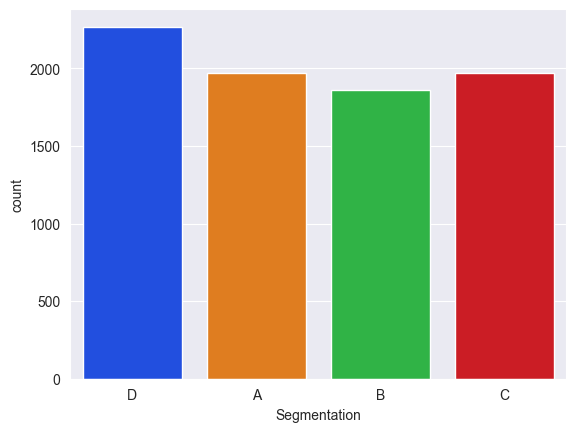

In [10]:
## Plotting the segments
sns.set_style('darkgrid')
cols=sns.color_palette('bright')

sns.countplot(data=train_df, x='Segmentation', palette=cols)


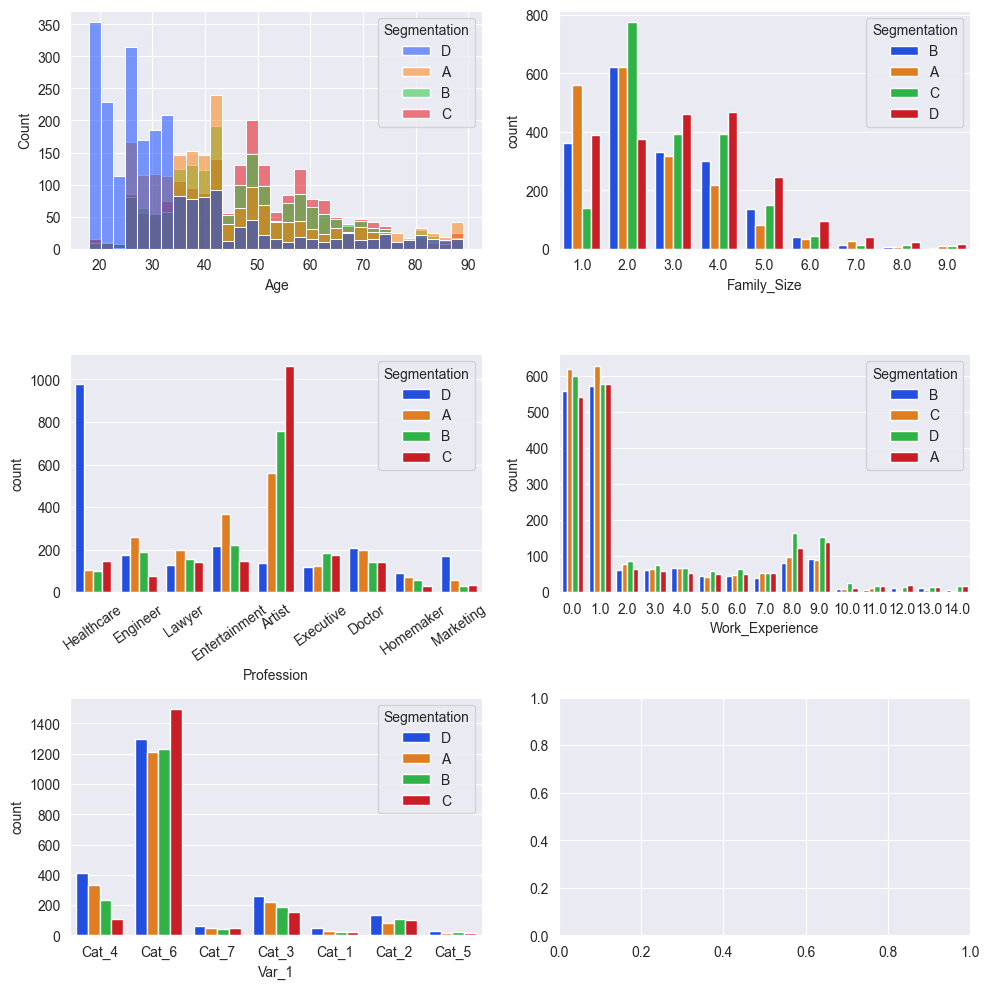

In [11]:
## Plotting details of the current segments
fig, axs = plt.subplots(3, 2, figsize=(10,10))

sns.set_style('darkgrid')
cols=sns.color_palette('bright')

sns.histplot(data=train_df, x='Age', hue='Segmentation', palette=cols, ax=axs[0,0])
sns.countplot(data=train_df, x='Family_Size', hue='Segmentation', palette=cols, ax=axs[0,1])
ax3 = sns.countplot(data=train_df, x='Profession', hue='Segmentation', palette=cols, ax=axs[1,0])
sns.countplot(data=train_df, x='Work_Experience', hue='Segmentation', palette=cols, ax=axs[1,1])
sns.countplot(data=train_df, x='Var_1', hue='Segmentation', palette=cols, ax=axs[2,0])

ax3.set_xticklabels(ax3.get_xticklabels(), rotation=35)

fig.tight_layout()

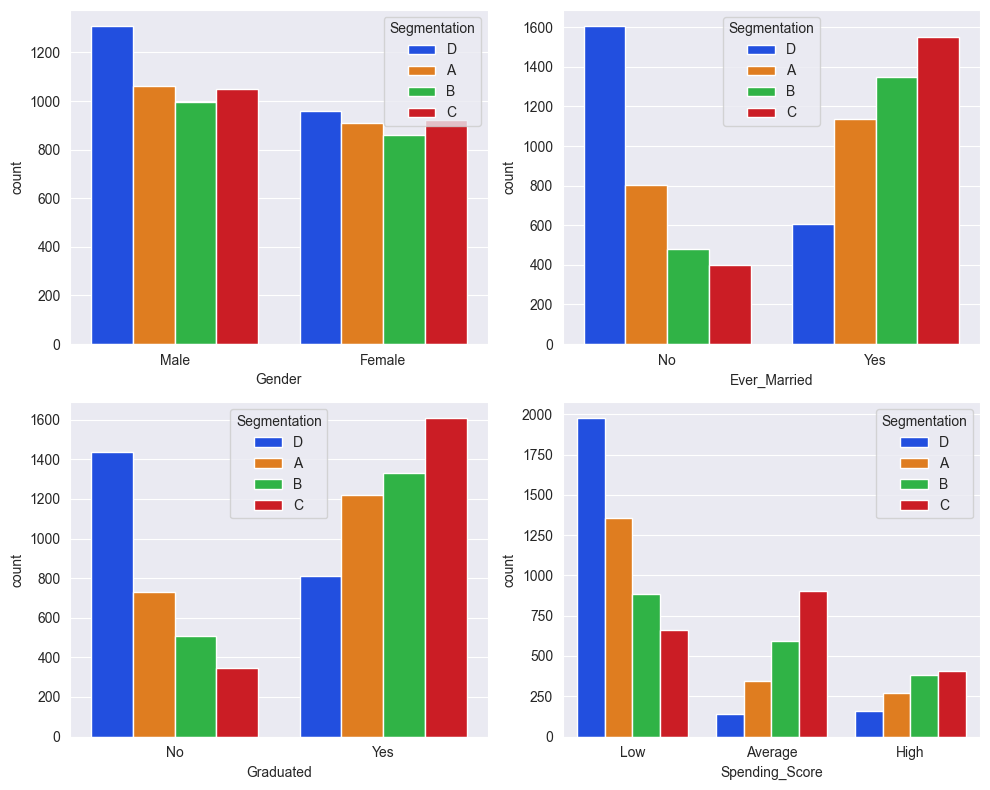

In [12]:
## Plotting details of the current segments
fig, axs = plt.subplots(2, 2, figsize=(10,8))

sns.set_style('darkgrid')
cols=sns.color_palette('bright')

sns.countplot(data=train_df, x='Gender', hue='Segmentation', palette=cols, ax=axs[0,0])
sns.countplot(data=train_df, x='Ever_Married', hue='Segmentation', palette=cols, ax=axs[0,1])
sns.countplot(data=train_df, x='Graduated', hue='Segmentation', palette=cols, ax=axs[1,0])
sns.countplot(data=train_df, x='Spending_Score', hue='Segmentation', palette=cols, ax=axs[1,1])

fig.tight_layout()

In [13]:
train_df.groupby('Segmentation')[['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']].agg(pd.Series.mode)

,Gender,Ever_Married,Graduated,Profession,Spending_Score
Segmentation,,,,,
A,Male,Yes,Yes,Artist,Low
B,Male,Yes,Yes,Artist,Low
C,Male,Yes,Yes,Artist,Average
D,Male,No,No,Healthcare,Low


In [14]:
train_df.groupby('Segmentation')[['Age', 'Work_Experience', 'Family_Size']].mean()

,Age,Work_Experience,Family_Size
Segmentation,,,
A,44.924949,2.874578,2.439531
B,48.200215,2.378151,2.696970
C,49.144162,2.240771,2.974559
D,33.390212,3.021717,3.232624


### Current customer segment insights:

#### Overall market
* The segments are quite balanced in customer numbers
* Artist is the biggest profession
* Most appear to have only 1-2 years of work experience, however there's a lot of missing data from this column so this is likely an overrepresentation

#### Segment A
* The majority are in their mid-20s to early-40s with most in their early-40s
* Most likely to work in the arts or entertainment
* More have graduated than those who haven't but there's a significant number of non-graduates
* More have been married than those who haven't but there's a siginificant number of non-married customers
* Most have a low spending score
* Most have a family size of 1-2

#### Segment B
* Most are concentrated around mid-30s to 50
* The majority are artists
* Most have graduated
* Most have been married
* Most are in the low spending category but there is a significant distribution across each spending score
* The majority have a family size of 2. Most have a family size of 1-4

#### Segment C
* The majority are in their late-40s to mid-60s, with most nearing 50
* The majority are artists
* Highest proportion of graduates
* Highest proportion of those who are married
* Most have an average spending score and they are the biggest group of high spenders
* The majority have a family size of 2. A significant amount have a family of 3 and 4

#### Segment D
* Skew towards a younger age range
* The majority work in healthcare
* Most haven't graduated (perhaps partly due to their age)
* Most have never been married (also perhaps partly due to their age)
* Have a low spending score
* Dominate across the larger family sizes. Most have a family size of 4 but there's a significant amount with families of 1-3.
* All segments have more men than women but Segment D has the widest gap

#### Conclusion
There's some overlap between these segments, so let's use machine learning models to see if there's a more effective way of clustering the market.

## Data cleaning

<Axes: >

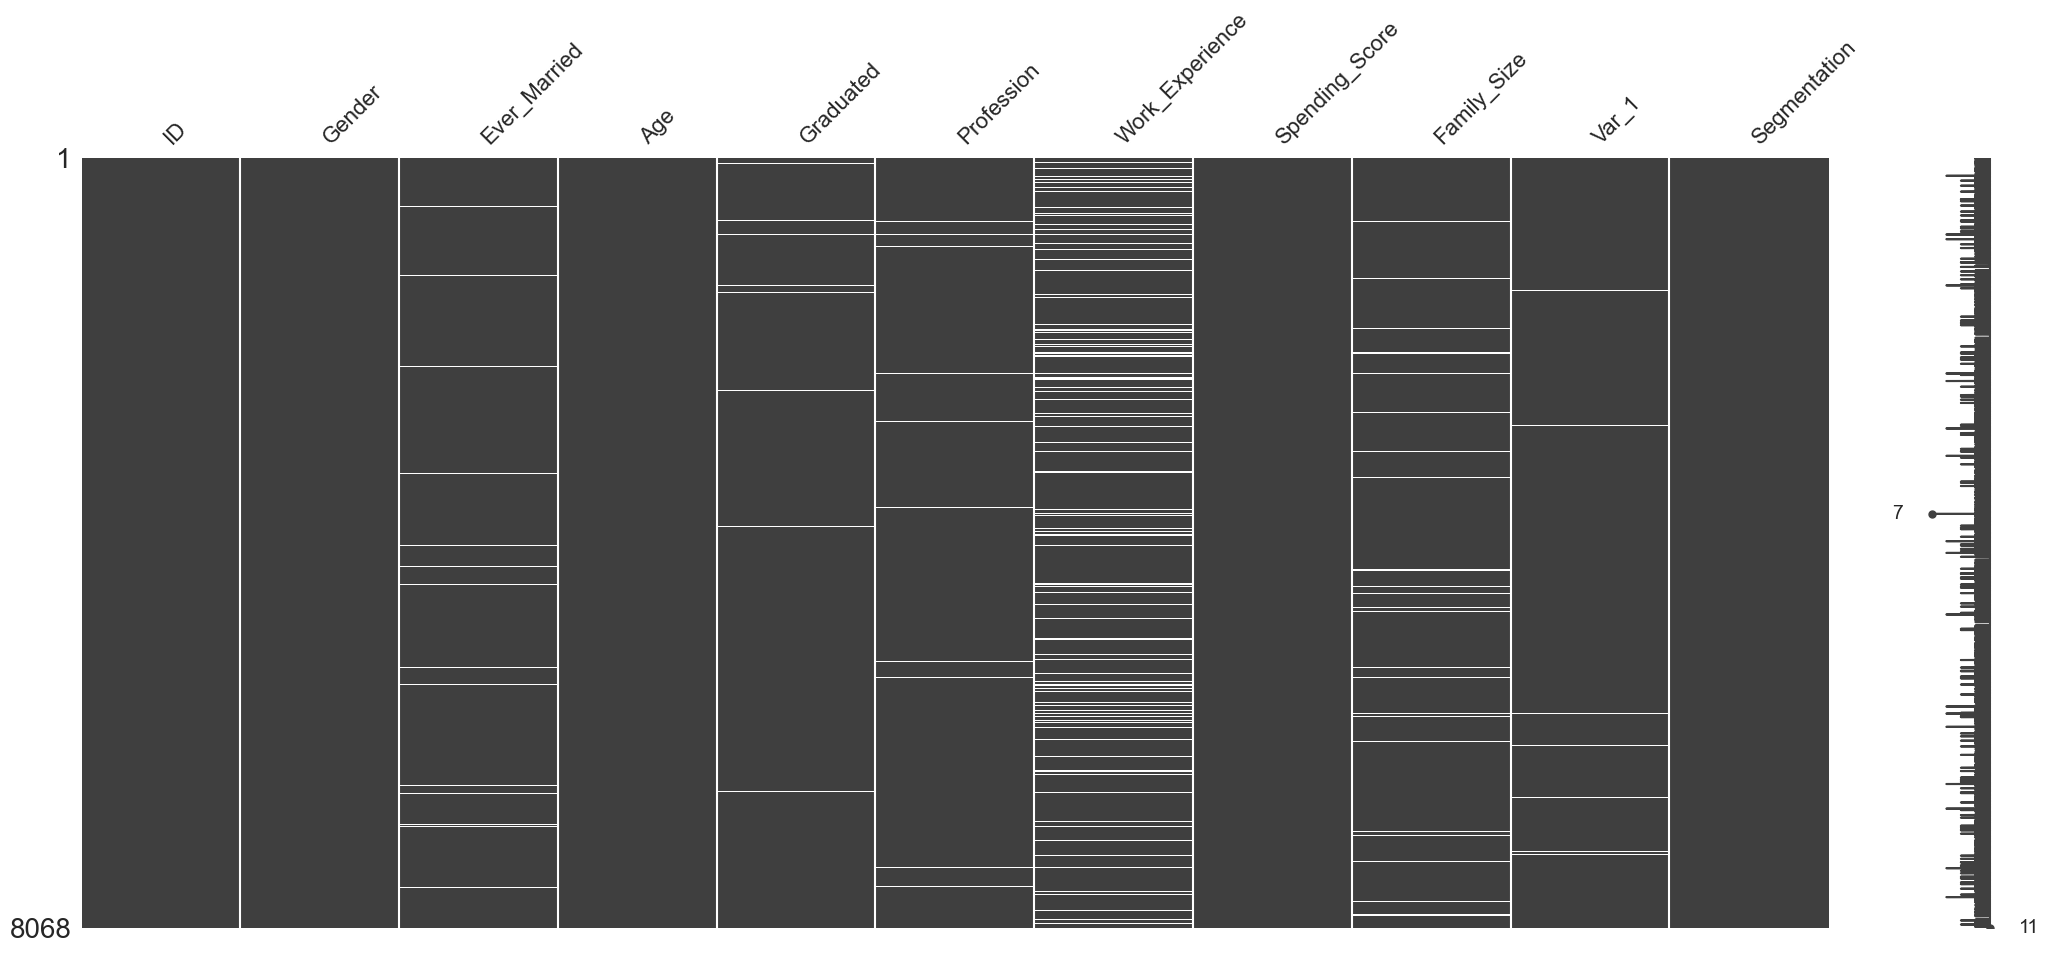

In [15]:
## Visualising null values
msno.matrix(train_df)

<Axes: >

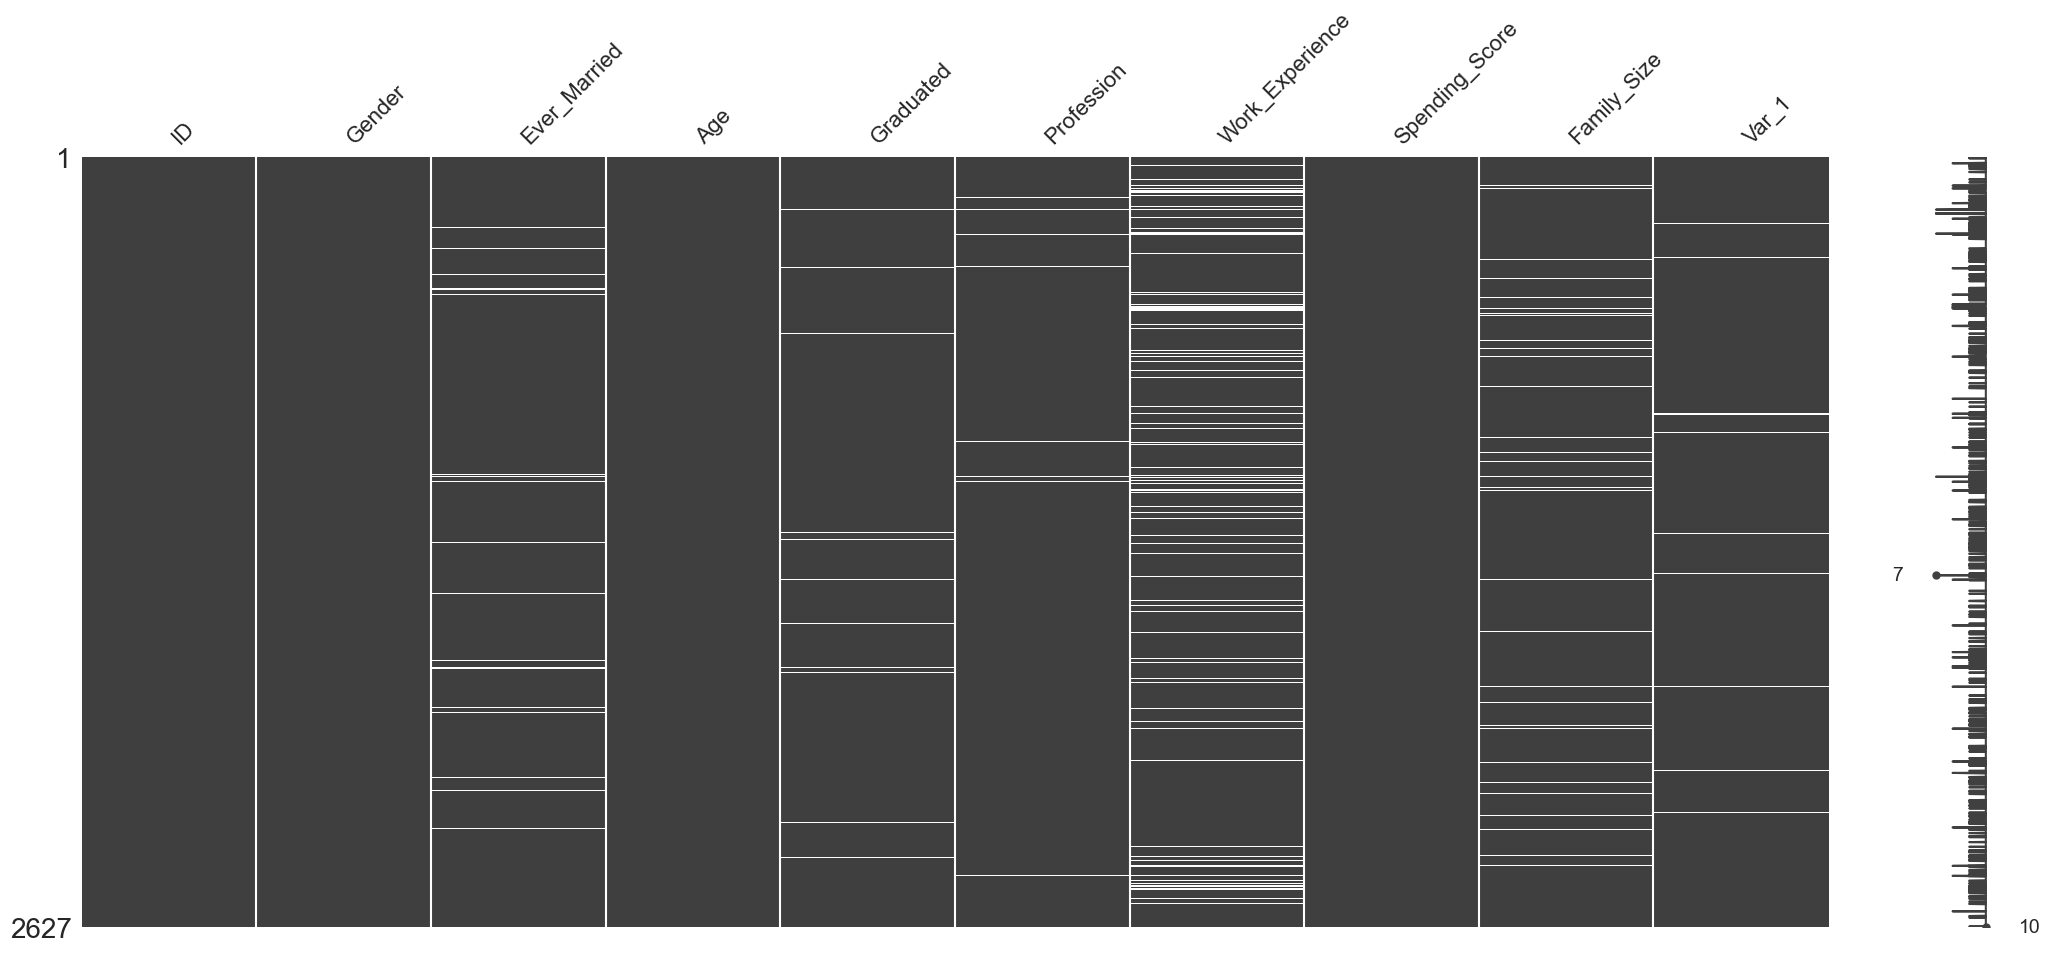

In [16]:
msno.matrix(test_df)

We can see several null values that need to be dealt with.

In [17]:
## Move Segmentation column to the front of training data for easy viewing
train_df = train_df[['Segmentation'] + [x for x in train_df.columns if x != 'Segmentation']]

In [18]:
## Mapping categorical values to numerical values in the training dataset
train_df_mapped = train_df.copy()

train_df_mapped['Segmentation'] = train_df_mapped['Segmentation'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3})
train_df_mapped['Gender'] = train_df_mapped['Gender'].map({'Male': 0, 'Female': 1})
train_df_mapped['Ever_Married'] = train_df_mapped['Ever_Married'].map({'No': 0, 'Yes': 1})
train_df_mapped['Graduated'] = train_df_mapped['Graduated'].map({'No': 0, 'Yes': 1})
train_df_mapped['Spending_Score'] = train_df_mapped['Spending_Score'].map({'Low': 0, 'Average': 1, 'High': 3})
train_df_mapped['Var_1'] = train_df_mapped['Var_1'].map({'Cat_4': 4, 'Cat_6': 6, 'Cat_7': 7, 'Cat_3': 3, 'Cat_1': 1, 'Cat_2': 2, 'Cat_5': 5})
train_df_mapped['Profession'] = train_df_mapped['Profession'].map({'Healthcare': 1, 'Engineer': 2, 'Lawyer': 3, 'Entertainment': 4, 'Artist': 5, 'Executive': 6, 'Doctor': 7, 'Homemaker': 8, 'Marketing': 9})
train_df_mapped.head()

,Segmentation,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,3,462809,0,0.0,22,0.0,1.0,1.0,0,4.0,4.0
1,0,462643,1,1.0,38,1.0,2.0,NaN,1,3.0,4.0
2,1,466315,1,1.0,67,1.0,2.0,1.0,0,1.0,6.0
3,1,461735,0,1.0,67,1.0,3.0,0.0,3,2.0,6.0
4,0,462669,1,1.0,40,1.0,4.0,NaN,3,6.0,6.0


In [19]:
## Mapping categorical values to numerical values in the test dataset
test_df_mapped = test_df.copy()

test_df_mapped['Gender'] = test_df_mapped['Gender'].map({'Male': 0, 'Female': 1})
test_df_mapped['Ever_Married'] = test_df_mapped['Ever_Married'].map({'No': 0, 'Yes': 1})
test_df_mapped['Graduated'] = test_df_mapped['Graduated'].map({'No': 0, 'Yes': 1})
test_df_mapped['Spending_Score'] = test_df_mapped['Spending_Score'].map({'Low': 0, 'Average': 1, 'High': 3})
test_df_mapped['Var_1'] = test_df_mapped['Var_1'].map({'Cat_4': 4, 'Cat_6': 6, 'Cat_7': 7, 'Cat_3': 3, 'Cat_1': 1, 'Cat_2': 2, 'Cat_5': 5})
test_df_mapped['Profession'] = test_df_mapped['Profession'].map({'Healthcare': 1, 'Engineer': 2, 'Lawyer': 3, 'Entertainment': 4, 'Artist': 5, 'Executive': 6, 'Doctor': 7, 'Homemaker': 8, 'Marketing': 9})
test_df_mapped.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,1,1.0,36,1.0,2.0,0.0,0,1.0,6.0
1,458994,0,1.0,37,1.0,1.0,8.0,1,4.0,6.0
2,458996,1,1.0,69,0.0,NaN,0.0,0,1.0,6.0
3,459000,0,1.0,59,0.0,6.0,11.0,3,2.0,6.0
4,459001,1,0.0,19,0.0,9.0,NaN,0,4.0,6.0


In [20]:
## Scaling the variables in the training dataset
scaler = MinMaxScaler()

train_df_mapped.iloc[:, 2:11] = scaler.fit_transform(train_df_mapped.iloc[:, 2:11])
train_df_scaled = pd.DataFrame(train_df_mapped, columns=train_df.columns)
train_df_scaled.head()

,Segmentation,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,3,462809,0,0.0,0.056338,0.0,0.000,0.071429,0.000000,0.375,0.500000
1,0,462643,1,1.0,0.281690,1.0,0.125,NaN,0.333333,0.250,0.500000
2,1,466315,1,1.0,0.690141,1.0,0.125,0.071429,0.000000,0.000,0.833333
3,1,461735,0,1.0,0.690141,1.0,0.250,0.000000,1.000000,0.125,0.833333
4,0,462669,1,1.0,0.309859,1.0,0.375,NaN,1.000000,0.625,0.833333


In [21]:
## Scaling the variables in the test dataset
test_df_mapped.iloc[:, 1:10] = scaler.fit_transform(test_df_mapped.iloc[:, 1:10])
test_df_scaled = pd.DataFrame(train_df_mapped, columns=test_df.columns)
test_df_scaled.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,462809,0,0.0,0.056338,0.0,0.000,0.071429,0.000000,0.375,0.500000
1,462643,1,1.0,0.281690,1.0,0.125,NaN,0.333333,0.250,0.500000
2,466315,1,1.0,0.690141,1.0,0.125,0.071429,0.000000,0.000,0.833333
3,461735,0,1.0,0.690141,1.0,0.250,0.000000,1.000000,0.125,0.833333
4,462669,1,1.0,0.309859,1.0,0.375,NaN,1.000000,0.625,0.833333


In [22]:
## Fill null values with KNNImputer in training data
imputer = KNNImputer(n_neighbors=5)
train_df_scaled = imputer.fit_transform(train_df_scaled)
train_df_imputed = pd.DataFrame(train_df_scaled, columns=train_df.columns)
train_df_imputed.head()

,Segmentation,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,3.0,462809.0,0.0,0.0,0.056338,0.0,0.000,0.071429,0.000000,0.375,0.500000
1,0.0,462643.0,1.0,1.0,0.281690,1.0,0.125,0.200000,0.333333,0.250,0.500000
2,1.0,466315.0,1.0,1.0,0.690141,1.0,0.125,0.071429,0.000000,0.000,0.833333
3,1.0,461735.0,0.0,1.0,0.690141,1.0,0.250,0.000000,1.000000,0.125,0.833333
4,0.0,462669.0,1.0,1.0,0.309859,1.0,0.375,0.228571,1.000000,0.625,0.833333


In [23]:
## Fill null values in the test data
test_df_scaled = imputer.fit_transform(test_df_scaled)
test_df_imputed = pd.DataFrame(test_df_scaled, columns=test_df.columns)
test_df_imputed.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,462809.0,0.0,0.0,0.056338,0.0,0.000,0.071429,0.000000,0.375,0.500000
1,462643.0,1.0,1.0,0.281690,1.0,0.125,0.200000,0.333333,0.250,0.500000
2,466315.0,1.0,1.0,0.690141,1.0,0.125,0.071429,0.000000,0.000,0.833333
3,461735.0,0.0,1.0,0.690141,1.0,0.250,0.000000,1.000000,0.125,0.833333
4,462669.0,1.0,1.0,0.309859,1.0,0.375,0.271429,1.000000,0.625,0.833333


In [24]:
## Checking for any leftover nulls
print(train_df_imputed.isna().sum())
print(test_df_imputed.isna().sum())

Segmentation       0
ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64
ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64


In [25]:
## Insert Segmentation column into test data
test_df_imputed.insert(0, 'Segmentation', '')
test_df.insert(0, 'Segmentation', '')

## K-Means Clustering

In [26]:
## Selecting the training data
X = train_df_imputed.iloc[:, 2:11]

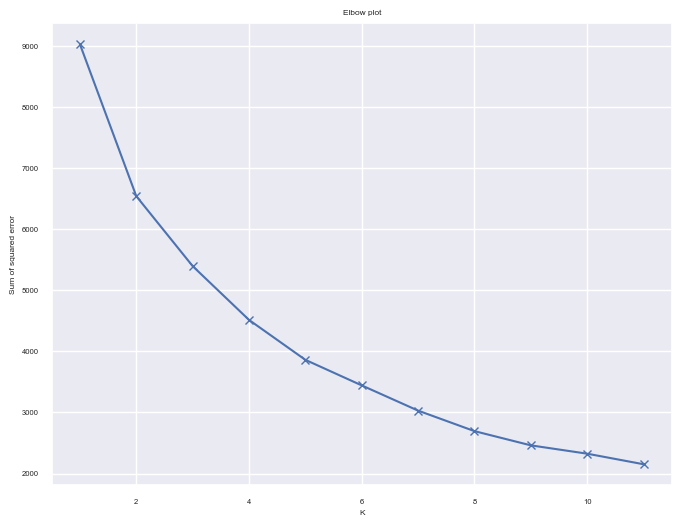

In [78]:
## Finding the optimum number of clusters 
elb_plot = []
k_range = range(1,12)
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(X)
    elb_plot.append(km.inertia_)

## Plot the elbow chart
plt.figure(figsize=(8,6))
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.title('Elbow plot')
plt.plot(k_range, elb_plot, marker='x')

In [82]:
import sklearn.cluster as cluster
SK = range(2,13)
sil_score = []
for i in SK:
    labels=cluster.KMeans(n_clusters=i,init="k-means++").fit(X).labels_
    score = silhouette_score(X,labels,metric="euclidean")
    sil_score.append(score)
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(silhouette_score(X,labels,metric="euclidean")))

Silhouette score for k(clusters) = 2 is 0.2734748978804857
Silhouette score for k(clusters) = 3 is 0.2642336546996274
Silhouette score for k(clusters) = 4 is 0.3044262004347776
Silhouette score for k(clusters) = 5 is 0.3165242819925668
Silhouette score for k(clusters) = 6 is 0.33067960513996264
Silhouette score for k(clusters) = 7 is 0.3593839207826656
Silhouette score for k(clusters) = 8 is 0.3939711652361485
Silhouette score for k(clusters) = 9 is 0.38229558355860505
Silhouette score for k(clusters) = 10 is 0.3873211504311767
Silhouette score for k(clusters) = 11 is 0.39208108270599995
Silhouette score for k(clusters) = 12 is 0.38381309785536305


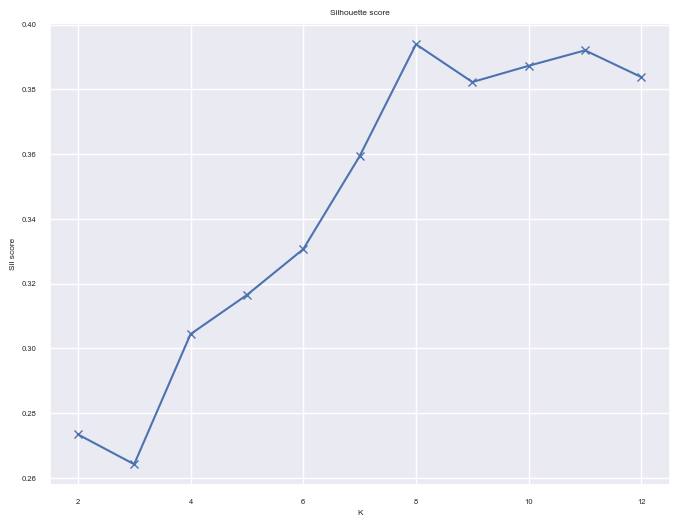

In [83]:
## Plot the line chart
plt.figure(figsize=(8,6))
plt.xlabel('K')
plt.ylabel('Sil score')
plt.title('Silhouette score')
plt.plot(SK, sil_score, marker='x')

In [28]:
## Dimensionality reduction with PCA
pca = PCA(n_components=2)
X_principle = pca.fit_transform(X)

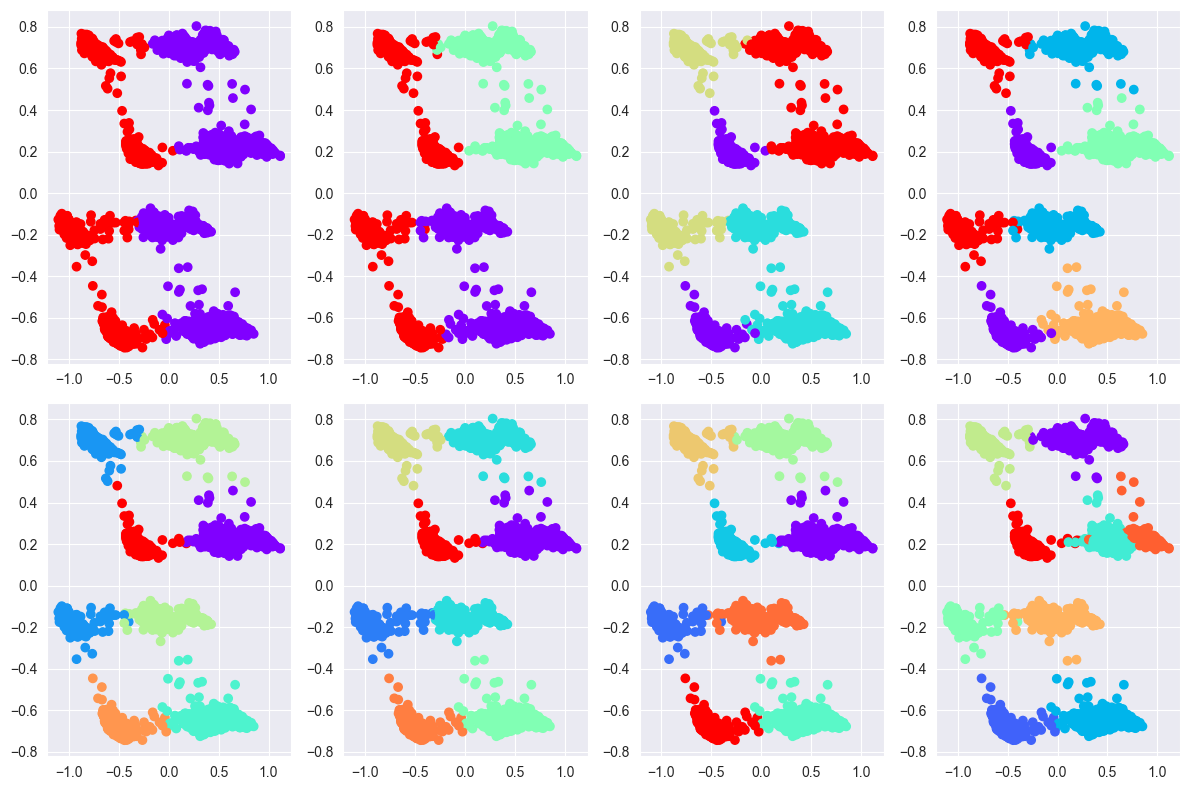

In [29]:
## Building various clustering models to test optimum number of clusters
kmeans2 = KMeans(n_clusters = 2)
kmeans2.fit(X)
kmeans3 = KMeans(n_clusters = 3)
kmeans3.fit(X)
kmeans4 = KMeans(n_clusters = 4)
kmeans4.fit(X)
kmeans5 = KMeans(n_clusters = 5)
kmeans5.fit(X)
kmeans6 = KMeans(n_clusters = 6)
kmeans6.fit(X)
kmeans7 = KMeans(n_clusters = 7)
kmeans7.fit(X)
kmeans8 = KMeans(n_clusters = 8)
kmeans8.fit(X)
kmeans9 = KMeans(n_clusters = 9)
kmeans9.fit(X)

## Plotting scatter plots to check optimum number of clusters
fig, axs = plt.subplots(2, 4, figsize=(12,8))

sns.set_style('darkgrid')

axs[0][0].scatter(X_principle[:,0], X_principle[:,1], c=kmeans2.labels_, cmap='rainbow')
axs[0][1].scatter(X_principle[:,0], X_principle[:,1], c=kmeans3.labels_, cmap='rainbow')
axs[0][2].scatter(X_principle[:,0], X_principle[:,1], c=kmeans4.labels_, cmap='rainbow')
axs[0][3].scatter(X_principle[:,0], X_principle[:,1], c=kmeans5.labels_, cmap='rainbow')
axs[1][0].scatter(X_principle[:,0], X_principle[:,1], c=kmeans6.labels_, cmap='rainbow')
axs[1][1].scatter(X_principle[:,0], X_principle[:,1], c=kmeans7.labels_, cmap='rainbow')
axs[1][2].scatter(X_principle[:,0], X_principle[:,1], c=kmeans8.labels_, cmap='rainbow')
axs[1][3].scatter(X_principle[:,0], X_principle[:,1], c=kmeans9.labels_, cmap='rainbow')

fig.tight_layout()

According to the silhouette scores and scatter plots, the optimal number of clusters for the given data and clustering technique is 8, although the weak elbow chart and low silhouette scores aren't the best.

In [164]:
## Select and fit the model
kmeans8.fit(X)

KMeans()

In [165]:
## Making predictions
KM_pred = kmeans8.predict(X)

In [166]:
## Showing output of prediction model
KM_output = pd.DataFrame({'ID': train_df_imputed.ID, 'Cluster': KM_pred})
KM_output.head()

,ID,Cluster
0,462809.0,3
1,462643.0,4
2,466315.0,4
3,461735.0,0
4,462669.0,4


In [167]:
## Inserting outputs into training dataset
train_df['KMCluster'] = KM_output['Cluster']
train_df['KMCluster'] = train_df['KMCluster'].map({0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8})
train_df.head(10)

,Segmentation,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,KMCluster,HCCluster
0,D,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,4,4
1,A,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,5,3
2,B,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,5,3
3,B,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,1,1
4,A,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,5,3
5,C,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,6,6
6,C,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,7,8
7,D,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,3,7
8,D,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,5,3
9,C,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,5,3


<Axes: xlabel='KMCluster', ylabel='count'>

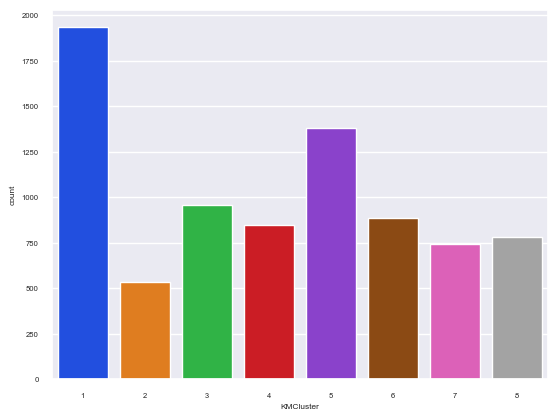

In [168]:
## Plotting the segments
sns.set_style('darkgrid')
cols=sns.color_palette('bright')

sns.countplot(data=train_df, x='KMCluster', palette=cols)

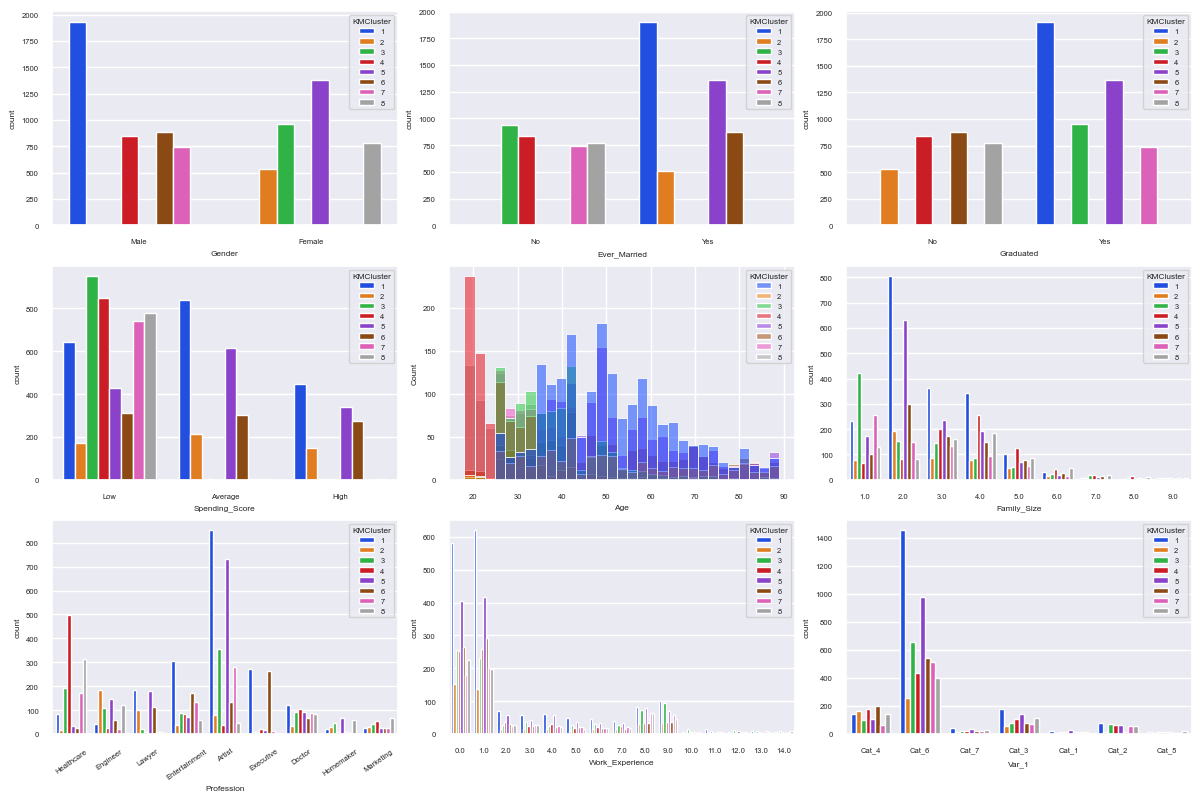

In [169]:
## Plotting new customer segments
fig, axs = plt.subplots(3, 3, figsize=(12,8))

sns.set_style('darkgrid')
cols=sns.color_palette('bright')

sns.countplot(data=train_df, x='Gender', hue='KMCluster', palette=cols, ax=axs[0,0])
sns.countplot(data=train_df, x='Ever_Married', hue='KMCluster', palette=cols, ax=axs[0,1])
sns.countplot(data=train_df, x='Graduated', hue='KMCluster', palette=cols, ax=axs[0,2])
sns.countplot(data=train_df, x='Spending_Score', hue='KMCluster', palette=cols, ax=axs[1,0])
sns.histplot(data=train_df, x='Age', hue='KMCluster', palette=cols, ax=axs[1,1])
sns.countplot(data=train_df, x='Family_Size', hue='KMCluster', palette=cols, ax=axs[1,2])
ax3 = sns.countplot(data=train_df, x='Profession', hue='KMCluster', palette=cols, ax=axs[2,0])
sns.countplot(data=train_df, x='Work_Experience', hue='KMCluster', palette=cols, ax=axs[2,1])
sns.countplot(data=train_df, x='Var_1', hue='KMCluster', palette=cols, ax=axs[2,2])

ax3.set_xticklabels(ax3.get_xticklabels(), rotation=35)

fig.tight_layout()

In [172]:
## Finding means and modes of new customer segments
train_df.groupby('KMCluster')[['Age', 'Work_Experience', 'Family_Size']].mean()

,Age,Work_Experience,Family_Size
KMCluster,,,
1,51.186143,2.321918,2.695860
2,50.652256,2.661470,2.884086
3,37.706374,3.480136,2.326711
4,26.301176,2.358739,3.750925
5,51.778261,2.458003,2.617053
6,51.555180,2.160207,3.015187
7,36.093960,3.260870,2.494350
8,28.368286,2.958153,3.458449


In [173]:
train_df.groupby('KMCluster')[['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']].agg(pd.Series.mode)

,Gender,Ever_Married,Graduated,Profession,Spending_Score
KMCluster,,,,,
1,Male,Yes,Yes,Artist,Average
2,Female,Yes,No,Engineer,Average
3,Female,No,Yes,Artist,Low
4,Male,No,No,Healthcare,Low
5,Female,Yes,Yes,Artist,Average
6,Male,Yes,No,Executive,Low
7,Male,No,Yes,Artist,Low
8,Female,No,No,Healthcare,Low


### K-Means customer segment insights:

#### Segment 1
* Largest segment
* 50s
* Male
* Graduate
* Primarily artists
* Married
* Family size of 2
* Average spending score but may fall into other categories

#### Segment 2
* Smallest segment
* 25-50
* Female
* Non-graduate
* Primarily engineers and lawyers
* Married
* Family size of 2
* Average spending score but also fall into other categories

#### Segment 3
* Smallest segment
* 30s
* Female
* Graduate
* Primarily work in arts or healthcare
* Unmarried
* Family size of 1
* Low spending score

#### Segment 4
* 20s
* Male
* Non-graduate
* Primarily work in healthcare
* Unmarried
* Family size of 3-4
* Low spending score

#### Segment 5
* 50s
* Female
* Graduate
* Primarily artists
* Married
* Family size of 2
* Average spending score but also fall into other categories

#### Segment 6
* 50s
* Male
* Non-graduate
* Primarily executives
* Married
* Family size of 2+
* Falls evenly into each spending score category

#### Segment 7
* 30s
* Male
* Graduate
* Primarily work in arts, healthcare, and entertainment
* Unmarried
* Family size of 1
* Low spending score

#### Segment 8
* 20s
* Female
* Non-graduate
* Primarily work in healthcare
* Unmarried
* Family size of 3-4
* Low spending score

## Hierarchical Clustering

In [38]:
## Dimensionality reduction with PCA
pca = PCA(n_components=2)
X_principle = pca.fit_transform(X)

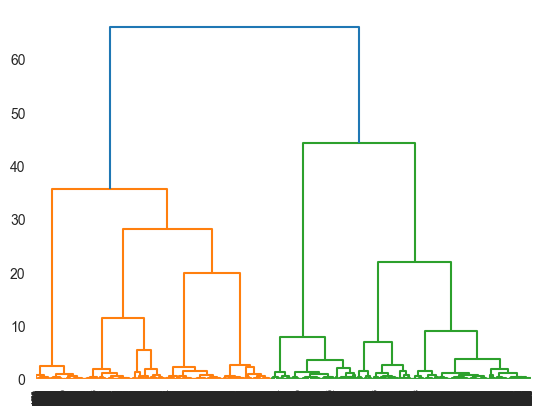

In [39]:
## Creating a dendrogram
ward_clustering = linkage(X_principle, method="ward", metric="euclidean")
dendrogram(ward_clustering)
plt.show()

In [84]:
## Building various clustering models to test optimum number of clusters
hc2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
hc3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hc4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
hc5 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
hc6 = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
hc7 = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
hc8 = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
hc9 = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')

## Finding silhouette scores
HCSK = range(2,11)
sil_score_hc = []
for i in HCSK:
    labels=cluster.AgglomerativeClustering(n_clusters=i).fit(X_principle).labels_
    score = silhouette_score(X_principle,labels,metric="euclidean")
    sil_score_hc.append(score)
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(silhouette_score(X_principle,labels,metric="euclidean")))

Silhouette score for k(clusters) = 2 is 0.426591158560869
Silhouette score for k(clusters) = 3 is 0.49287201110735185
Silhouette score for k(clusters) = 4 is 0.5340041556415698
Silhouette score for k(clusters) = 5 is 0.6118988457507477
Silhouette score for k(clusters) = 6 is 0.6689266666029906
Silhouette score for k(clusters) = 7 is 0.734134052028264
Silhouette score for k(clusters) = 8 is 0.7470055616577648
Silhouette score for k(clusters) = 9 is 0.7426056857384201
Silhouette score for k(clusters) = 10 is 0.7384285955523707


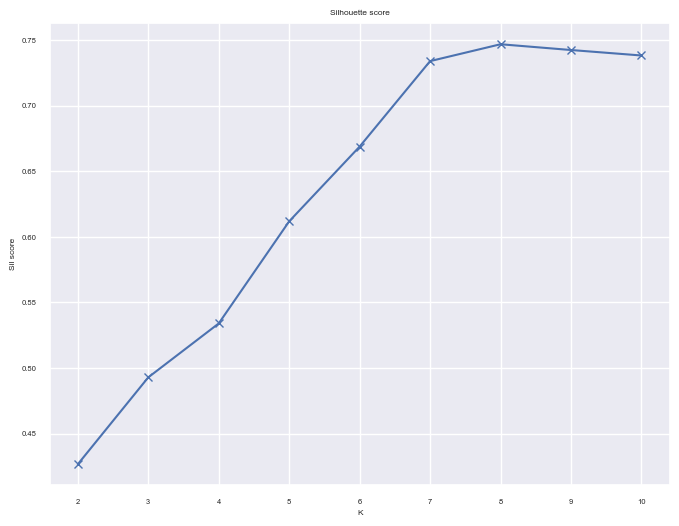

In [85]:
## Plot the line chart
plt.figure(figsize=(8,6))
plt.xlabel('K')
plt.ylabel('Sil score')
plt.title('Silhouette score')
plt.plot(HCSK, sil_score_hc, marker='x')

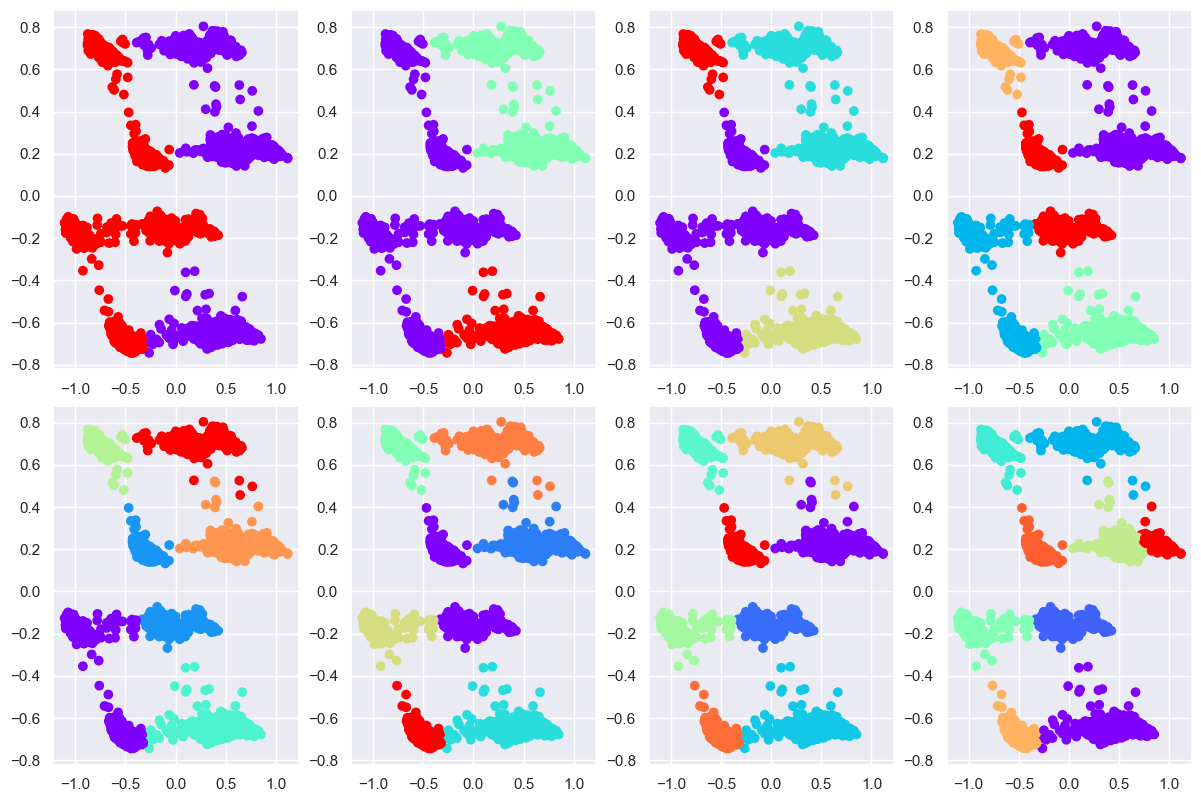

In [41]:
## Plotting scatter plots to check optimum number of clusters
fig, axs = plt.subplots(2, 4, figsize=(12,8))

sns.set_style('darkgrid')
sns.set(font_scale=0.5)

axs[0][0].scatter(X_principle[:,0], X_principle[:,1], c=hc2.labels_, cmap='rainbow')
axs[0][1].scatter(X_principle[:,0], X_principle[:,1], c=hc3.labels_, cmap='rainbow')
axs[0][2].scatter(X_principle[:,0], X_principle[:,1], c=hc4.labels_, cmap='rainbow')
axs[0][3].scatter(X_principle[:,0], X_principle[:,1], c=hc5.labels_, cmap='rainbow')
axs[1][0].scatter(X_principle[:,0], X_principle[:,1], c=hc6.labels_, cmap='rainbow')
axs[1][1].scatter(X_principle[:,0], X_principle[:,1], c=hc7.labels_, cmap='rainbow')
axs[1][2].scatter(X_principle[:,0], X_principle[:,1], c=hc8.labels_, cmap='rainbow')
axs[1][3].scatter(X_principle[:,0], X_principle[:,1], c=hc9.labels_, cmap='rainbow')

fig.tight_layout()

According to the silhouette scores and scatter plots, the optimal number of clusters for the given data and clustering technique is again 8.

In [127]:
## Fitting data with model 8
HC8_pred = hc8.fit_predict(X_principle)

## Showing output of prediction model
HC8_output = pd.DataFrame({'ID': train_df_imputed.ID, 'Cluster': HC8_pred})
HC8_output.head()

,ID,Cluster
0,462809.0,3
1,462643.0,2
2,466315.0,2
3,461735.0,0
4,462669.0,2


In [128]:
## Inserting outputs into training dataset
train_df['HCCluster'] = HC8_output['Cluster']
train_df['HCCluster'] = train_df['HCCluster'].map({0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8})
train_df.head(10)

,Segmentation,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,KMCluster,HCCluster
0,D,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,G,4
1,A,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,B,3
2,B,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B,3
3,B,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,D,1
4,A,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,B,3
5,C,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,F,6
6,C,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,A,8
7,D,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,E,7
8,D,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,B,3
9,C,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,B,3


<Axes: xlabel='HCCluster', ylabel='count'>

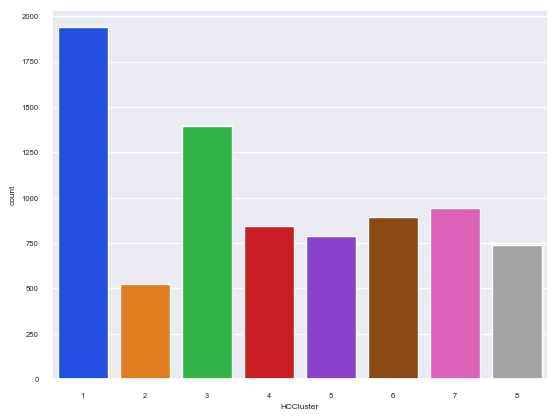

In [154]:
## Plotting the new segments
sns.set_style('darkgrid')
cols=sns.color_palette('bright')

sns.countplot(data=train_df, x='HCCluster', palette=cols)

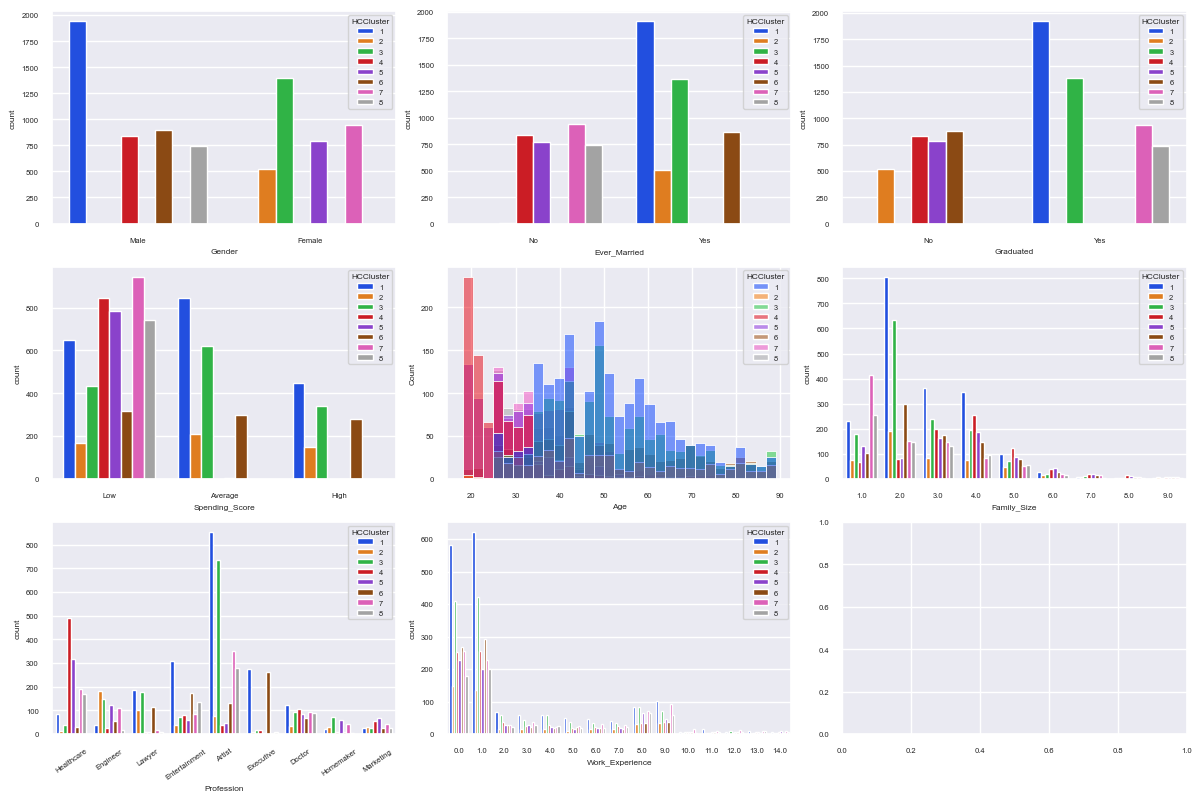

In [129]:
## Plotting the new segment details
fig, axs = plt.subplots(3, 3, figsize=(12,8))

sns.set_style('darkgrid')
cols=sns.color_palette('bright')
sns.set(font_scale=0.5)

sns.countplot(data=train_df, x='Gender', hue='HCCluster', palette=cols, ax=axs[0,0])
sns.countplot(data=train_df, x='Ever_Married', hue='HCCluster', palette=cols, ax=axs[0,1])
sns.countplot(data=train_df, x='Graduated', hue='HCCluster', palette=cols, ax=axs[0,2])
sns.countplot(data=train_df, x='Spending_Score', hue='HCCluster', palette=cols, ax=axs[1,0])
sns.histplot(data=train_df, x='Age', hue='HCCluster', palette=cols, ax=axs[1,1])
sns.countplot(data=train_df, x='Family_Size', hue='HCCluster', palette=cols, ax=axs[1,2])
ax3 = sns.countplot(data=train_df, x='Profession', hue='HCCluster', palette=cols, ax=axs[2,0])
sns.countplot(data=train_df, x='Work_Experience', hue='HCCluster', palette=cols, ax=axs[2,1])

ax3.set_xticklabels(ax3.get_xticklabels(), rotation=35)

fig.tight_layout()

In [130]:
## Finding means and modes of new customer segments
train_df.groupby('HCCluster')[['Age', 'Work_Experience', 'Family_Size']].mean()

,Age,Work_Experience,Family_Size
HCCluster,,,
1,51.181021,2.319088,2.695606
2,50.875717,2.664399,2.882000
3,51.700143,2.472941,2.614360
4,26.255042,2.364238,3.756522
5,28.432193,2.951359,3.454047
6,51.374720,2.157895,3.015099
7,37.628571,3.473563,2.327740
8,36.058030,3.269173,2.494318


In [131]:
train_df.groupby('HCCluster')[['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']].agg(pd.Series.mode)

,Gender,Ever_Married,Graduated,Profession,Spending_Score
HCCluster,,,,,
1,Male,Yes,Yes,Artist,Average
2,Female,Yes,No,Engineer,Average
3,Female,Yes,Yes,Artist,Average
4,Male,No,No,Healthcare,Low
5,Female,No,No,Healthcare,Low
6,Male,Yes,No,Executive,Low
7,Female,No,Yes,Artist,Low
8,Male,No,Yes,Artist,Low


### Hierarchical clustering customer segment insights:

#### Segment 1
* Largest segment
* 50s
* Male
* Graduates
* Primarily artists
* Married
* Family size of 2
* Average spending score but may fall into other categories

#### Segment 2
* Smallest segment
* 25-50
* Female
* Non-graduates
* Primarily engineers and lawyers
* Married
* Family size of 2
* Average spending score but also fall into other categories

#### Segment 3
* 50s
* Female
* Graduates
* Primarily artists
* Married
* Family size of 2
* Average spending score but also fall into other categories

#### Segment 4
* 20s
* Male
* Non-graduates
* Primarily work in healthcare
* Unmarried
* Family size of 4
* Low spending score

#### Segment 5
* 20s
* Female
* Non-graduates
* Primarily work in healthcare
* Unmarried
* Family size of 3-4
* Low spending score

#### Segment 6
* 50s
* Male
* Non-graduates
* Primarily executives
* Married
* Family size of 2+
* Falls evenly into each spending score category

#### Segment 7
* 30s
* Female
* Graduates
* Primarily work in arts or healthcare
* Unmarried
* Family size of 1
* Low spending score

#### Segment 8
* 30s
* Male
* Graduates
* Primarily work in arts, healthcare, and entertainment
* Unmarried
* Family size of 1-3
* Low spending score

## Conclusion and recommendations

* Both models produce near-identical segments, just with different labels.
* 8 customer segments is considered ideal for the dataset. These produced more defined segments that allow for more tailored marketing and outreach.
* The models performed well at separating binary categoires such as gender, marital status and graduate status. They were also good at separating out segments with low spending scores which is an important variable in sales and marketing.
* However, some segments can be joined together by age, gender, spending score etc. depending on company needs and strategies.

## Segmenting the test data for the new market

Both models produce similar results, so I'll use hierarchical clustering to group the new target market data.

This can then be used for strategising and outreach.

In [174]:
## Segmenting the test data for the model
X_test = test_df_imputed.iloc[:, 2:11]

## Dimensionality reduction with PCA
X_principle_test = pca.fit_transform(X_test)

## Fitting data with model 8
HC8_pred_test = hc8.fit_predict(X_principle_test)

## Showing output of prediction model
HC8_test_output = pd.DataFrame({'ID': test_df_imputed.ID, 'Cluster': HC8_pred_test})
HC8_test_output.head()

,ID,Cluster
0,462809.0,3
1,462643.0,2
2,466315.0,2
3,461735.0,0
4,462669.0,2


In [175]:
## Inserting Hierarchical Clustering segments into the training dataset's Segmentation column
hcsegment_df = test_df.copy()

hcsegment_df['Segmentation'] = HC8_test_output['Cluster']
hcsegment_df['Segmentation'] = hcsegment_df['Segmentation'].map({0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8})
hcsegment_df.head(10)

,Segmentation,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,4,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,3,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,3,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,1,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,3,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6
5,6,459003,Male,Yes,47,Yes,Doctor,0.0,High,5.0,Cat_4
6,8,459005,Male,Yes,61,Yes,Doctor,5.0,Low,3.0,Cat_6
7,7,459008,Female,Yes,47,Yes,Artist,1.0,Average,3.0,Cat_6
8,3,459013,Male,Yes,50,Yes,Artist,2.0,Average,4.0,Cat_6
9,3,459014,Male,No,19,No,Healthcare,0.0,Low,4.0,Cat_6
